# Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam,RMSprop
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

# Calculating Bollinger Bands

In [3]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [4]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [5]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [6]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Screener Algorithm

In [7]:
def screener(company):
    calls = ''
    puts = ''
    fail = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day !=-1:
                calls = ''
                puts = ''
                fail = f'{ticker} failed {current_status} {(day)*(-1)-1} day(s) ago'
            break
    return calls,puts,fail

# Screener

In [8]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_fails = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_fails!='':
            fails.append(company_fails)
    return calls,puts,fails


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_fails = screener(company)
    if company_calls!='':
            calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_fails!='':
        fails.append(company_fails)
    return calls,puts,fails

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_fails = screener(company)
    if company_calls!='':
            calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_fails!='':
        fails.append(company_fails)
    return calls,puts,fails

In [150]:
stock_calls,stock_puts,stock_fails = check_index(sp500)
#stock_calls,stock_puts,stock_fails = check_stock('AXP')
print(f'calls ({len(stock_calls)}): {stock_calls}\nputs ({len(stock_puts)}): {stock_puts}\nfails ({len(stock_fails)}): {stock_fails}')

calls (9): ['ADP', 'ADP', 'BALL', 'BIIB', 'HWM', 'IPG', 'JBHT', 'MU', 'RCL']
puts (0): []
fails (179): ['A failed call 2 day(s) ago', 'AAL failed call 1 day(s) ago', 'ABBV failed call 1 day(s) ago', 'ABT failed call 3 day(s) ago', 'AEP failed call 1 day(s) ago', 'ALK failed call 1 day(s) ago', 'ALL failed call 2 day(s) ago', 'AMCR failed call 1 day(s) ago', 'AON failed call 1 day(s) ago', 'APA failed call 1 day(s) ago', 'ATVI failed call 1 day(s) ago', 'A failed call 2 day(s) ago', 'AAL failed call 1 day(s) ago', 'ABBV failed call 1 day(s) ago', 'ABT failed call 3 day(s) ago', 'AEP failed call 1 day(s) ago', 'ALK failed call 1 day(s) ago', 'ALL failed call 2 day(s) ago', 'AMCR failed call 1 day(s) ago', 'AON failed call 1 day(s) ago', 'APA failed call 1 day(s) ago', 'ATVI failed call 1 day(s) ago', 'AVY failed call 1 day(s) ago', 'AXP failed call 4 day(s) ago', 'BAC failed call 2 day(s) ago', 'BBWI failed call 1 day(s) ago', 'BEN failed call 1 day(s) ago', 'BKNG failed call 3 day(s) ag

# Get pre/post market prices

In [ ]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = f'Premarket: {get_premarket_price(ticker)}'
    elif is_postmarket(current_hour):
        data = f'Postmarket: {get_postmarket_price(ticker)}'
    else:
        data = 'Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('AAPL',current_hour)

Not pre/post market


# Plotter

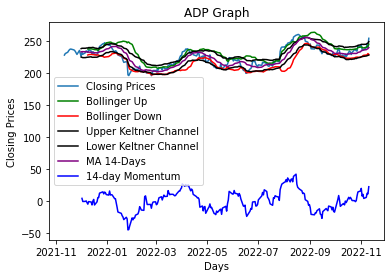

In [27]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'ADP'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()

# ML Predictions PART 1: Data Pre-Processing

In [24]:
# Step 1: Read data
from sklearn.model_selection import train_test_split


today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'ADP'
data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
dataset_train = gather_data(data)
##dataset_train['close-open'] = (dataset_train['close']-dataset_train['open']).shift(periods=1)
# Select features to be involved in training and prediction and target to predict
features = list(dataset_train[['open','upper_KC','lower_KC','bollinger_up','bollinger_down','MA']])#,'high','low','volume','momentum' REMOVED DUE TO NON-LINEARITY
target = list(dataset_train[['close']])
dataset_train.dropna(inplace=True)
X = dataset_train[features]
y = dataset_train[target]
# Scale data
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features].values)
# dataset_features_scaled = scaler.fit_transform(X)
# dataset_target_scaled = scaler.fit_transform(y)
# Split the data for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'X_train:\n{X_train}\n\nX_test:\n{X_test}\n\ny_train:\n{y_train}\n\ny_test:\n{y_test}')

(186, 6) (47, 6) (186, 1) (47, 1)
X_train:
                open  upper_KC  lower_KC  bollinger_up  bollinger_down  \
2022-02-08 -1.343385 -0.761885 -1.087787     -0.546791       -1.020348   
2022-01-24 -0.625923  0.410036  0.427138      1.067709        0.392794   
2022-04-11  0.777528 -0.059005  0.151139      0.218110       -0.432032   
2022-08-16  2.094268  1.320186  1.413896      1.141034        0.948927   
2022-08-15  1.916989  1.291286  1.155036      1.007417        0.786229   
...              ...       ...       ...           ...             ...   
2022-06-15 -1.261812 -0.898973 -0.866854     -0.593375       -0.930321   
2022-06-17 -1.681883 -1.102187 -1.077525     -0.464083       -1.182495   
2022-08-29  1.498845  1.854947  2.094554      1.747411        2.240286   
2022-03-30 -0.124920 -0.965591 -0.725492     -0.827692       -0.938656   
2022-09-06  0.819921  1.626981  1.812712      2.101536        1.768093   

                  MA  
2022-02-08 -1.243555  
2022-01-24  0.417319  

C:\Users\slogozzo\AppData\Local\Temp\ipykernel_3444\2537662752.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features].values)


# Check for linearity

In [25]:
for feature in features:
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train[feature], dataset_train['close'])
    print(f'At {feature}, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['volume'], dataset_train['close'])
# print(f'At volume, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['momentum'], dataset_train['close'])
# print(f'At momentum, r_value: {r_value**2}')

At open, r_value: 0.9519433698090913
At upper_KC, r_value: 0.665265443255927
At lower_KC, r_value: 0.7143442224407252
At bollinger_up, r_value: 0.5313978548555208
At bollinger_down, r_value: 0.5201349742309997
At MA, r_value: 0.7139115716418246


Surprisingly, we see that Volume and Momentum are correlated very little to Closing prices. Only 0.010511741252537113 for volume and 0.02194343991238041 for momentum.
Remember, r_value is between 0 and 1, where 0 is bad and 1 is good

# Now plot everything to double check for linearity at those values

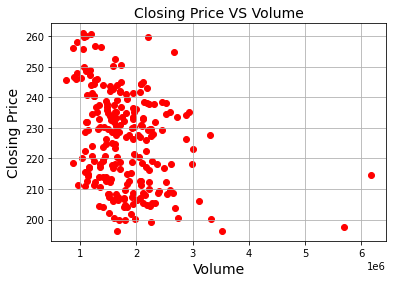

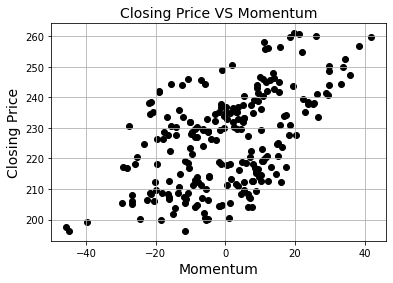

In [164]:
%matplotlib inline

plt.scatter(dataset_train['volume'], dataset_train['close'], color='red')
plt.title('Closing Price VS Volume', fontsize=14)
plt.xlabel('Volume', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.grid(True)
plt.show()

plt.scatter(dataset_train['momentum'], dataset_train['close'], color='black')
plt.title('Closing Price VS Momentum', fontsize=14)
plt.xlabel('Momentum', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.grid(True)
plt.show()

# Perform Multiple Linear Regression

In [50]:
import statsmodels.api as sm

X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
predictions = model.predict(X)
print(f'\nPredictions: {predictions}')

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     778.3
Date:                Fri, 11 Nov 2022   Prob (F-statistic):          6.91e-148
Time:                        16:35:36   Log-Likelihood:                -611.86
No. Observations:                 233   AIC:                             1238.
Df Residuals:                     226   BIC:                             1262.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            225.7319      0.222   1014.

In [51]:
# Train model using train data:
X_train = sm.add_constant(X_train) # adding a constant

model = sm.OLS(y_train, X_train).fit()
print(model.summary())
# Make predictions on test data
X_test = sm.add_constant(X_test)
predictions = model.predict(X_test)
print(f'\nPredictions: {predictions}')
print(f'\nActual data: {y_test}')


                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     709.7
Date:                Fri, 11 Nov 2022   Prob (F-statistic):          6.28e-122
Time:                        16:35:38   Log-Likelihood:                -478.97
No. Observations:                 186   AIC:                             971.9
Df Residuals:                     179   BIC:                             994.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            225.5579      0.238    947.

In [52]:
# Let's try making a prediction
real_data_today = scaler.transform([[254.21,250.04,230.05,247.63,229.97,238.8]])
real_data_today = np.insert(real_data_today[0], 0, 1) # Add constant like in the model to add a y-int
predicted = model.predict(real_data_today)
print(f'Price of {ticker} should go to ${predicted[0]}')

Price of ADP should go to $252.58592268434975
